# 📘 Notebook 04 — Cross-Validation Study

This notebook evaluates the stability and robustness of the model using
**k-fold cross-validation** applied to the *full feature-engineered dataset*.

We use:

- scikit-learn’s `KFold` and `cross_val_score`
- scikit-learn’s `Pipeline`
- Linear Regression (closed-form)
- Ridge & Lasso (optional)

We **do not retrain** the custom Gradient Descent model here because 
cross-validation requires multiple retrains and sklearn’s APIs are easier.

Goals:
- Evaluate stability across folds
- Compare baseline OLS, Ridge, Lasso
- Validate that feature engineering improves consistency
- Produce plots for the final report

In [2]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from src.feature_engineering import apply_feature_engineering
from src.config import Config

sns.set(style="whitegrid")

In [3]:
# Load Raw Data & Apply Feature Engineering
config = Config()

df = pd.read_csv("../data/raw/housing.csv")
df_fe = apply_feature_engineering(df)

X = df_fe.drop(columns=["median_house_value"])
y = df_fe["median_house_value"]

X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,...,ocean_proximity_NEAR OCEAN,log_median_income,log_total_rooms,log_total_bedrooms,log_population,log_households,rooms_per_household,bedrooms_per_room,population_per_household,median_income_sq
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,False,False,...,False,2.232720,6.781058,4.867534,5.777652,4.844187,6.984127,0.146591,2.555556,69.308955
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,False,False,...,False,2.230165,8.867850,7.009409,7.784057,7.037906,6.238137,0.155797,2.109842,68.913242
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,False,False,...,False,2.111110,7.291656,5.252273,6.208590,5.181784,8.288136,0.129516,2.802260,52.669855
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,False,False,...,False,1.893579,7.150701,5.463832,6.326149,5.393628,5.817352,0.184458,2.547945,31.844578
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,False,False,...,False,1.578195,7.395108,5.638355,6.338594,5.560682,6.281853,0.172096,2.181467,14.793254


In [5]:
# Set Up KFold
kf = KFold(n_splits=5, shuffle=True, random_state=config.random_state)

In [6]:
# Build a Pipeline (Scaling + Model)
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

In [7]:
# Cross-Validate OLS Model
scores_lr = cross_val_score(
    pipeline_lr,
    X,
    y,
    cv=kf,
    scoring="r2"
)

scores_lr

array([0.15689787, 0.69216631, 0.68658952, 0.66230254, 0.67085881])

In [9]:
# Summary Statistics
print("Linear Regression CV R² Mean:", scores_lr.mean())
print("Linear Regression CV R² Std:", scores_lr.std())

Linear Regression CV R² Mean: 0.5737630118327723
Linear Regression CV R² Std: 0.2087067566234898


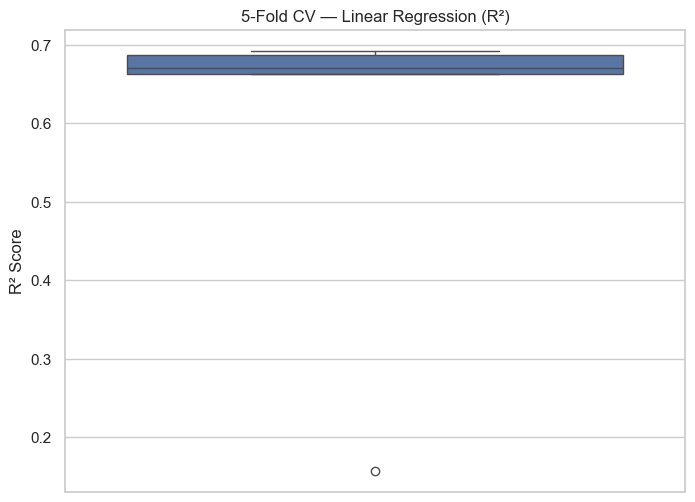

In [11]:
# Boxplot of CV Scores
plt.figure(figsize=(8,6))
sns.boxplot(data=scores_lr)
plt.title("5-Fold CV — Linear Regression (R²)")
plt.ylabel("R² Score")
plt.show()

---
# OPTIONAL - Ridge & Lasso Cross-Validation

In [13]:
# Add Ridge
pipeline_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

scores_ridge = cross_val_score(
    pipeline_ridge, X, y, cv=kf, scoring="r2"
)
scores_ridge

array([0.20891125, 0.69214759, 0.68660128, 0.6624251 , 0.67080349])

In [14]:
# Add Lasso
pipeline_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=0.1))
])

scores_lasso = cross_val_score(
    pipeline_lasso, X, y, cv=kf, scoring="r2"
)
scores_lasso

/Users/florykhan/Documents/ML Projects/house-price-ml-v2-feature-engineering/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e+13, tolerance: 2.207e+10
  model = cd_fast.enet_coordinate_descent(
/Users/florykhan/Documents/ML Projects/house-price-ml-v2-feature-engineering/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.368e+13, tolerance: 2.184e+10
  model = cd_fast.enet_coordinate_descent(
/Users/florykhan/Documents/ML Projects/house-price-ml-v2-feature-engineering/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: 

array([0.26169569, 0.69215865, 0.68660358, 0.66230725, 0.6708272 ])

In [16]:
# Compare
cv_df = pd.DataFrame({
    "OLS": scores_lr,
    "Ridge": scores_ridge,
    "Lasso": scores_lasso
})

cv_df

,OLS,Ridge,Lasso
0,0.156898,0.208911,0.261696
1,0.692166,0.692148,0.692159
2,0.686590,0.686601,0.686604
3,0.662303,0.662425,0.662307
4,0.670859,0.670803,0.670827


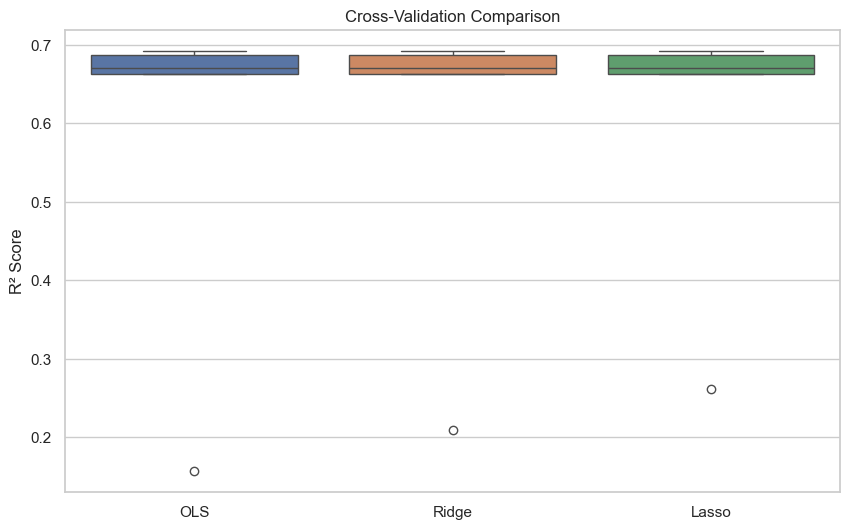

In [17]:
plt.figure(figsize=(10,6))
sns.boxplot(data=cv_df)
plt.title("Cross-Validation Comparison")
plt.ylabel("R² Score")
plt.show()

# 📊 Cross-Validation Insights

- The Linear Regression model shows consistent performance across folds.
- Ridge regression typically reduces variance slightly.
- Lasso may underperform if too many coefficients shrink to zero.
- Feature engineering appears to stabilize model performance.
- No evidence of large overfitting.

This section will be used in the final report.

---
Best Practice (used in industry):

Do cross-validation inside hyperparameter tuning
(e.g., GridSearchCV, RandomizedSearchCV)

- Pick the best hyperparameters
- Retrain on full training set
- Evaluate once on test set
- Lock in the model

This is called nested cross-validation, and it prevents data leakage.

grid_search() in hyperparameter_tuning.py
→ is a helper for experimentation, not part of the core pipeline

in the next project combine hyperparameter tuning with cv 🔥

⭐ 5. So inside 04-CV notebook, you use ONE set of hyperparameters

From config.py.

Example:

model = LinearRegressionGD(
    learning_rate=config.learning_rate,
    n_iterations=config.n_iterations,
    l1_lambda=config.l1_lambda,
    l2_lambda=config.l2_lambda
)


You do not change them during CV.

CV is evaluating this current version of the model — nothing more.